In [12]:
%pylab inline

import pandas as pd
import xgboost as xgb
import spac
import pickle
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')
rcParams['figure.figsize'] = (12,7)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload
reload(spac)

<module 'spac' from '/Users/isaacdrachman/GitHub/Trading/spac.py'>

In [6]:
# Compare MonteCarlo implementations between 
# mc1: price KO condition as daily-on-close
# mc2: price KO condition as 20/30 prev days 
# MC2 is more accurate since less likely to KO is worth somewhat more. But horribly slow...
noise = np.random.normal(size=(10000, 5*252))

a = time.time()
px = spac.mc_price(10.0, 5.0, 0.35, noise).mean()
b = time.time()
print(f'mc1: ${px:.4f} {b-a:.4f} seconds')

a = time.time()
px = spac.mc_price2(10.0, 5.0, 0.35, noise).mean()
b = time.time()
print(f'mc2: ${px:.4f} {b-a:.4f} seconds')

mc1: $2.2378 0.1468 seconds
mc2: $2.4616 7.6023 seconds


### Speed-up pricing by training a simple ML model on MC1
1. Build 2d grid of spot and vol points. Spot values are not equi-distant since more common in the 9-15 range. 
2. Price warrant using MC1 and European call using BS.
3. Create dataset of (spot, vol) vs. target where target can optionally be the warrant price or the premium ratio of warrant / vanilla call. 
4. Split into train/test and fit XGBRegressor.

I found best results using the ratio (warrant price / vanilla price) as the target variable. This makes intuitive sense since the warrant is bounded above by the vanilla price and the ratio will have less variability than the warrant price outright.

In [7]:
# Increment spot by $1 from $3.00 to $20.00 but add density every $0.50 between $9.00 and $15.00
spots = np.concatenate([[3.0,4.0,5.0,6.0,7.0,8.0],np.linspace(9.0, 15.0, 13),[16.0,17.0,18.0,19.0,20.0]])

# Increment vol by around 3pt between 6% and 100%
vols  = np.linspace(0.06, 1.0, 32)

In [8]:
df = pd.DataFrame()
with tqdm(total=len(spots)*len(vols)) as pbar:
    for spot in spots:
        for vol in vols:
            noise = np.random.normal(size=(10000, 5*252))
            pvs = spac.mc_price(spot, 5, vol, noise)
            bs  = spac.bs_price(spot, 5, vol)
            row = {'spot': spot, 'vol': vol, 'pv': pvs.mean(), 'bs': bs}
            df = df.append(row, ignore_index=True)
            pbar.update(1)

100%|██████████| 768/768 [06:09<00:00,  2.08it/s]


In [9]:
# Save this data for future use. "noisy" tag means new noise is generated for each valuation.
df[['spot','vol','bs','pv']].to_csv('mc_outputs_5y_noisy.csv')

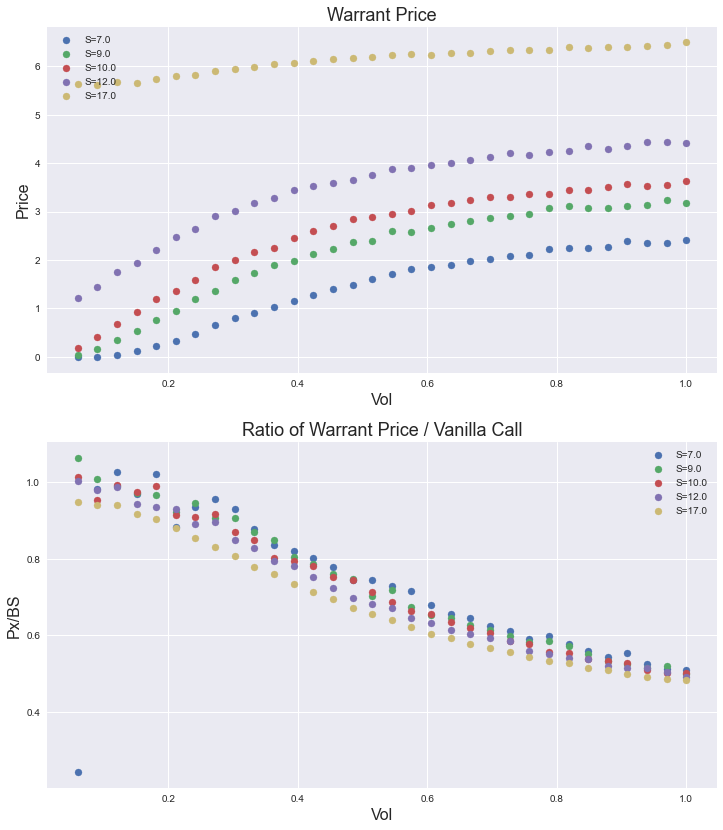

In [18]:
fig, ax = subplots(2, figsize=(12,14))

for S in [7.0, 9.0, 10.0, 12.0, 17.0]:
    ax[0].scatter(df.loc[df.spot == S].vol, df.loc[df.spot == S].pv, label='S={:.1f}'.format(S))
    ratio_px = df.loc[df.spot == S].pv / df.loc[df.spot == S].bs
    ax[1].scatter(df.loc[df.spot == S].vol, ratio_px, label='S={:.1f}'.format(S))

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')

ax[0].set_title('Warrant Price', fontsize=18)
ax[0].set_xlabel('Vol', fontsize=16)
ax[0].set_ylabel('Price', fontsize=16)

ax[1].set_title('Ratio of Warrant Price / Vanilla Call', fontsize=18)
ax[1].set_xlabel('Vol', fontsize=16)
ax[1].set_ylabel('Px/BS', fontsize=16);

In [43]:
X = df[['spot','vol']]

ratio = True
y = df.pv/df.bs if ratio else df.pv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

def score(mdl, train=True, ratio=False):
    if train:
        X, y = X_train, y_train
        ratio = df.iloc[X_train.index].bs if ratio else 1.0
    else:
        X, y = X_test, y_test
        ratio = df.iloc[X_test.index].bs if ratio else 1.0
    return (mdl.predict(X)*ratio - y*ratio).abs()

In [48]:
mdl = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, n_jobs=-1)
mdl.fit(X_train, y_train, eval_set=((X_train, y_train), (X_test, y_test)), verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

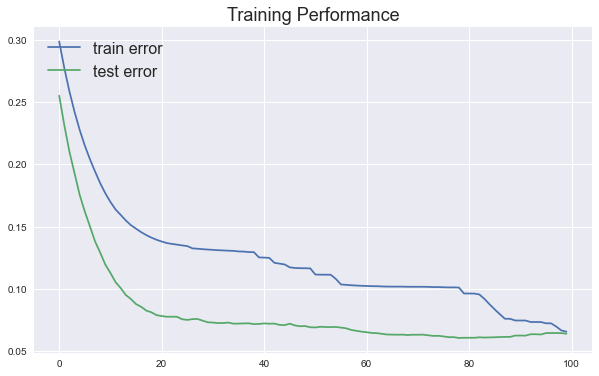

In [49]:
figsize(10,6)
plot(mdl.evals_result()['validation_0']['rmse'][:], label='train error')
plot(mdl.evals_result()['validation_1']['rmse'][:], label='test error')
title('Training Performance', fontsize=18)
legend(loc='upper left', fontsize=16);

In [50]:
# Predicting $ price.
print('train avg abs error: ${:.4f}'.format(score(mdl, train=True, ratio=ratio).mean()))
print('train max abs error: ${:.4f}'.format(score(mdl, train=True, ratio=ratio).max()))
print('')
print('test avg abs error:  ${:.4f}'.format(score(mdl, train=False, ratio=ratio).mean()))
print('test max abs error:  ${:.4f}'.format(score(mdl, train=False, ratio=ratio).max()))

train avg abs error: $0.0224
train max abs error: $0.1133

test avg abs error:  $0.0286
test max abs error:  $0.0944


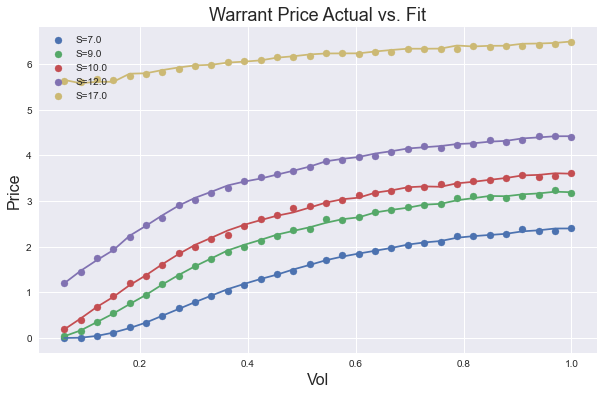

In [52]:
for S in [7.0, 9.0, 10.0, 12.0, 17.0]:
    subset = df.loc[df.spot == S]
    scatter(subset.vol, subset.pv, label='S={:.1f}'.format(S))
    plot(subset.vol, mdl.predict(subset[['spot','vol']]) * subset.bs)
    
legend(loc='upper left')
title('Warrant Price Actual vs. Fit', fontsize=18)
xlabel('Vol', fontsize=16)
ylabel('Price', fontsize=16);

In [53]:
# Next, compute delta numerically as difference btwn predicted warrant prices.
def delta(spot: float, vol: float, mdl):
    x = pd.DataFrame({'spot': spot - 0.10, 'vol': vol},index=[0])
    px_x = mdl.predict(x) * spac.bs_price(spot - 0.10, 5.0, vol)
    y = pd.DataFrame({'spot': spot + 0.10, 'vol': vol},index=[0])
    px_y = mdl.predict(y) * spac.bs_price(spot + 0.10, 5.0, vol)
    return (px_y - px_x)/(2*0.1)

In [54]:
delta(30, 0.30, mdl)

array([0.82242966], dtype=float32)

In [56]:
pickle.dump(mdl, open('warrant-mdl-noisy.obj', 'wb'))

In [57]:
mdl.predict(pd.DataFrame({'spot': 9.9, 'vol': 0.1},index=[0]))[0] * spac.bs_price(9.9, 5.0, 0.1)

0.4705134824611492

In [58]:
mdl.predict(pd.DataFrame({'spot': 6.0, 'vol': 0.85},index=[0]))[0] * spac.bs_price(6.0, 5.0, 0.85)

1.8900690438780945